In [1]:
! pip3 install evaluate
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir(next((root for root, _, files in os.walk(".") if "dsait4090_project_location" in files), "."))
    print(f'Google Colab: {os.getcwd()}')
except ImportError:
    print(f'Local: {os.getcwd()}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/drive
Google Colab: /content/drive/Othercomputers/macbook_pro/

In [2]:
%load_ext autoreload
%autoreload

import logging
import torch
from torch import nn
from time import time

from src.models.math_roberta import MATH_ROBERTA_CONFIG
from src.models.deberta_v3 import DEBERTA_V3_CONFIG
from src.models.elastic_roberta import ELASTIC_ROBERTA_CONFIG
from src.models.bart_large_mnli import BART_LARGE_MNLI_CONFIG
from src.models.gpt2 import GPT2_CONFIG
from src.models.roberta_large_mnli import ROBERTA_LARGE_MNLI_CONFIG
from src.common import DATA_PATH, read_data, get_device, DOC, NO_DECOMPOSITION, GPT3_5_TURBO, FLANT5
from src.classification_training import ClassificationTraining
from src.quantemp_processor import QuantempProcessor

logging.basicConfig(level=logging.ERROR)

device = get_device()

def data_path(decomposition: str, split: str):
    if decomposition == 'doc':
        path = f'raw_data/{split}_claims.json'
    elif decomposition == 'no_decomposition':
        return f'no_decomposition/{split}_evidences_no_decomposition.json'
    else:
        path = f'{decomposition}/{split}_evidences_decomposed_{decomposition}.json'

    return os.path.join(DATA_PATH, path)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CUDA: 1, use Tesla T4


In [3]:
%autoreload

config = [
    (GPT2_CONFIG, DOC),
    (GPT2_CONFIG, NO_DECOMPOSITION),
    (GPT2_CONFIG, GPT3_5_TURBO),
    (GPT2_CONFIG, FLANT5),
]

print(len(config))
for model, decomposition in config:
    print(f'{model["name"]} - {decomposition}')

4
gpt2 - doc
gpt2 - no_decomposition
gpt2 - gpt3.5-turbo
gpt2 - flant5


(1 / 4)  GPT2 | DOC   


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

doc


  0%|          | 0/9935 [00:00<?, ?it/s]

  0%|          | 0/3084 [00:00<?, ?it/s]

  0%|          | 0/2495 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Starting new training from epoch 1

EPOCH 1


train:   0%|          | 0/621 [00:00<?, ?it/s]

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.980 | 58.04
   eval:  0.973 | 58.19
Saved best model: best_model_01


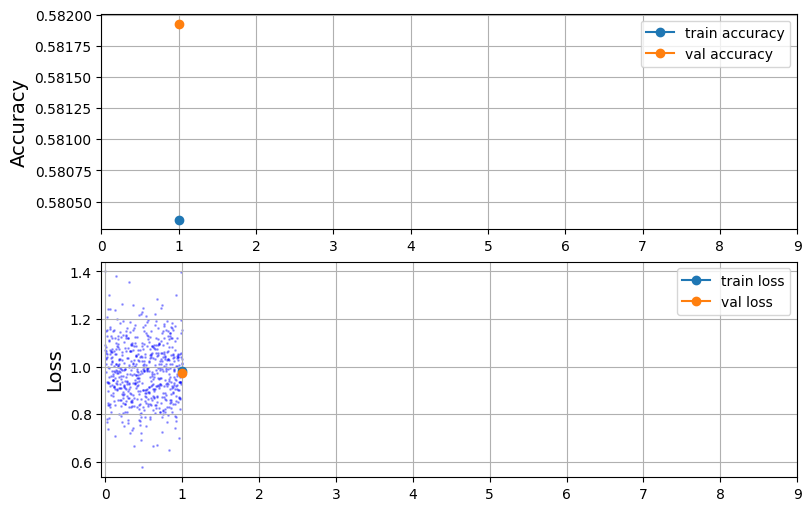


EPOCH 2


train:   0%|          | 0/621 [00:00<?, ?it/s]

val:   0%|          | 0/193 [00:00<?, ?it/s]

          loss  | accuracy
  train:  0.972 | 58.08
   eval:  0.973 | 58.19


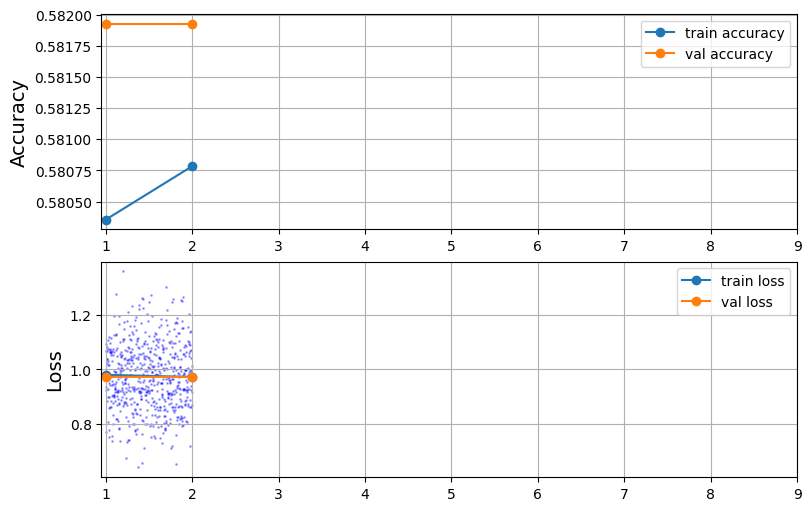

Early stopping counter: 1/2

EPOCH 3


train:   0%|          | 0/621 [00:00<?, ?it/s]

In [ ]:
%autoreload

DATA_LIMIT = None

for i, (model_config, decomposition) in enumerate(config):
    t0 = time()
    model_name = model_config['name']
    model_type = model_config['model']
    tokenizer_type = model_config['tokenizer']

    print(f"{'='*60}\n({i+1} / {len(config)})  {model_name.upper()} | {decomposition.upper()}   \n{'='*60}")

    train_claims = read_data(data_path(decomposition, 'train'))[:DATA_LIMIT]
    val_claims = read_data(data_path(decomposition, 'val'))[:DATA_LIMIT]
    test_claims = read_data(data_path(decomposition, 'test'))[:DATA_LIMIT]

    data_processor = QuantempProcessor(tokenizer_type(), decomposition=decomposition)
    train_dataset = data_processor.transform(train_claims)
    val_dataset = data_processor.transform(val_claims)
    test_dataset = data_processor.transform(test_claims)

    model = model_type().to(device)

    training = ClassificationTraining(
        model_name=f"{model_name}_{decomposition}",
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        model=model,
        optimizer=torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8),
        loss_function=nn.CrossEntropyLoss(),
        batch_size=16,
        device=device,
        random_state=42
    )

    training.start_new_training()
    training.train(epochs=20, patience=2)
    training.evaluate_best_model(test_claims, test_dataset)

    t1 = time()
    print(f"Time: {(t1 - t0) / 60:.2f} min")

